### Step 1: Import the necessary packages

In [1]:
import sys
assert sys.version_info >=(3, 5)

import tensorflow as tf
assert tf.__version__ >= "2.0"
import sklearn
import keras
import tensorflow_datasets as tfds

#import other common packages
import os
import numpy as np
from pathlib import Path

#specify fig printing
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

#load tensorboard
%load_ext tensorboard

#set random seed
np.random.seed(42)
tf.random.set_seed(42)



### Step 2: Load dataset

#### 2.1 Download data

In [2]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065301781/1065301781 [==============================] - 37s 0us/step


In [3]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [4]:
train_files

['/root/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [5]:
eval_files

['/root/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']

In [6]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
  test_classes = test_classes_file.readlines()

  with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [7]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [8]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

#### 2.2 Load data using tf datasets

In [9]:
def parse(data_batch):
  feature_descriptions = {
      "ink": tf.io.VarLenFeature(dtype=tf.float32),
      "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
      "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
  }
  examples = tf.io.parse_example(data_batch, feature_descriptions)
  flat_sketches = tf.sparse.to_dense(examples["ink"])
  sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
  lengths = examples["shape"][:,0]
  labels = examples["class_index"][:,0]
  return sketches, lengths, labels

In [10]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
  dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
  if cache:
    dataset = dataset.cache()
  if shuffle_buffer_size:
    dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
  return dataset.prefetch(1)

In [11]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [12]:
for sketches, lengths, labels in train_set.take(1):
  print("sketches =", sketches)
  print("lengths =", lengths)
  print("labels =", labels)

sketches = tf.Tensor(
[[[-0.0944882  -0.04663213  0.        ]
  [-0.08661417  0.04145078  0.        ]
  [-0.03937007  0.05181348  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.04313726 -0.14960629  0.        ]
  [ 0.06274509 -0.40551183  0.        ]
  [ 0.04313726 -0.12598425  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [-0.19607842 -0.03174603  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.12790698  0.01960784  0.        ]
  [-0.02906978  0.2117647   0.        ]
  [-0.04651159  0.06274509  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

#### 2.3 Visualize the sketches

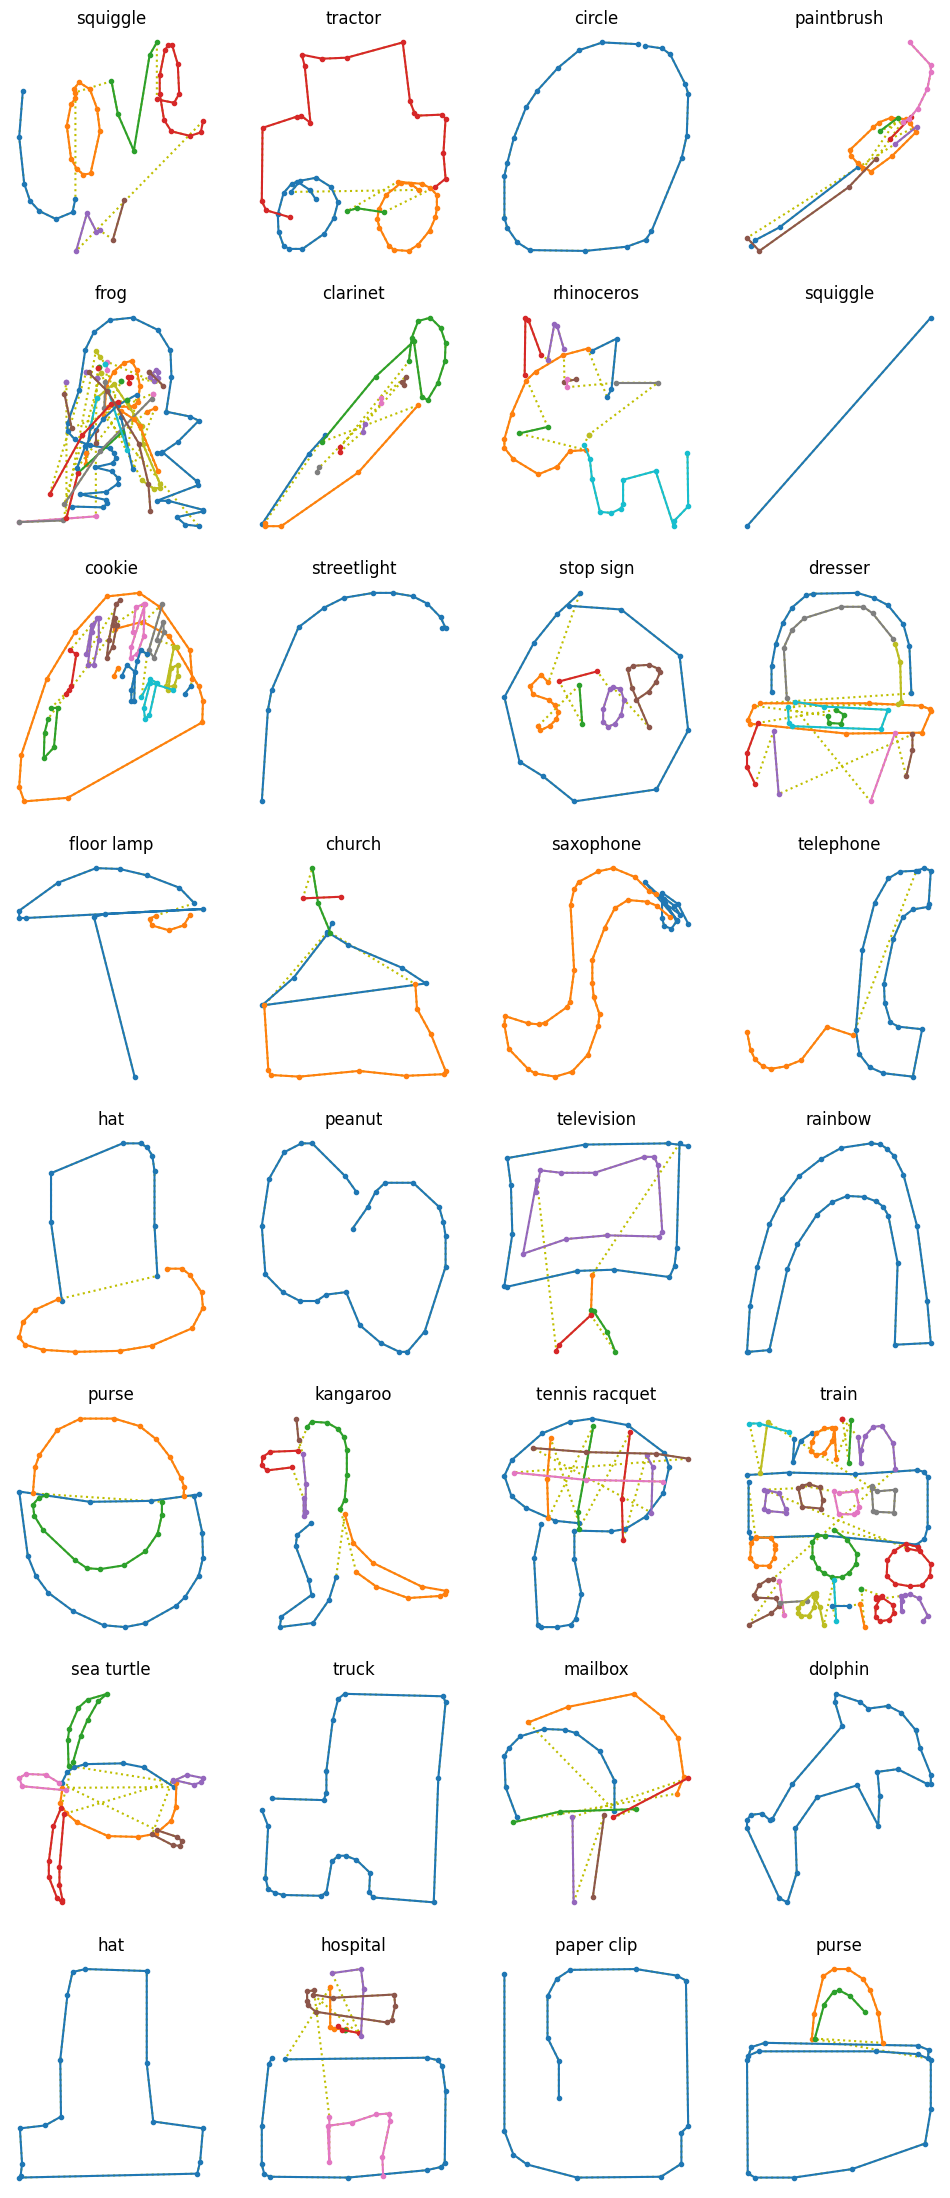

In [13]:
def draw_sketch(sketch, label=None):
  origin = np.array([[0., 0., 0.]])
  sketch = np.r_[origin, sketch]
  stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
  coordinates = np.cumsum(sketch[:, :2], axis=0)
  strokes = np.split(coordinates, stroke_end_indices + 1)
  title = class_names[label.numpy()] if label is not None else "Try to guess"
  plt.title(title)
  plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
  for stroke in strokes:
    plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
  plt.axis("off")

def draw_sketches(sketches, lengths, labels):
  n_sketches = len(sketches)
  n_cols = 4
  n_rows = (n_sketches - 1) // n_cols + 1
  plt.figure(figsize=(n_cols*3, n_rows * 3.5))
  for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
    plt.subplot(n_rows, n_cols, index + 1)
    draw_sketch(sketch[:length], label)
  plt.show()

for sketches, lengths, labels in train_set.take(1):
  draw_sketches(sketches, lengths, labels)

#### 2.4 Crop long sketches
Most of the sketches are made up of less than 100 points

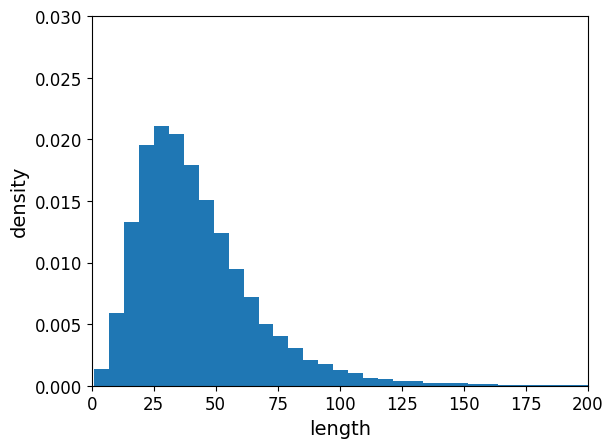

In [14]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [15]:
def crop_long_sketches(dataset, max_length=100):
  return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

### Step 3: Create the model and fit to data

In [16]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(256, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
optimizer=optimizer,
metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2, validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 1383s 13ms/step - loss: 4.6903 - accuracy: 0.0903 - sparse_top_k_categorical_accuracy: 0.2335 - val_loss: 3.5753 - val_accuracy: 0.2240 - val_sparse_top_k_categorical_accuracy: 0.4857
Epoch 2/2
107813/107813 [==============================] - 1436s 13ms/step - loss: 2.9529 - accuracy: 0.3345 - sparse_top_k_categorical_accuracy: 0.6192 - val_loss: 2.5292 - val_accuracy: 0.4128 - val_sparse_top_k_categorical_accuracy: 0.7005


#### 3.2 test model

In [17]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

5392/5392 [==============================] - 33s 6ms/step


In [18]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.6070609

1/1 [==============================] - 1s 1s/step


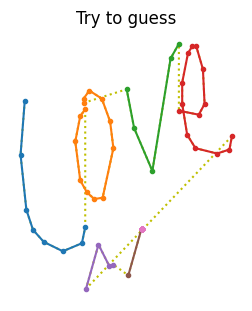

Top-5 predictions:
 1. animal migration 26.635%
 2. blueberry 13.509%
 3. yoga 4.638%
 4. sun 4.492%
 5. stethoscope 3.519%
answer: squiggle


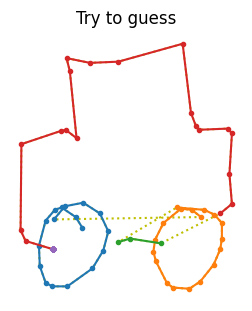

Top-5 predictions:
 1. tractor 14.543%
 2. snorkel 6.705%
 3. car 6.293%
 4. police car 5.295%
 5. pickup truck 4.835%
answer: tractor


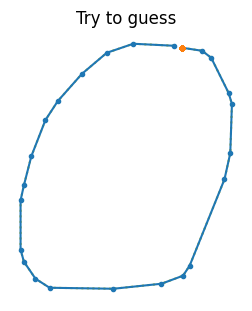

Top-5 predictions:
 1. octagon 18.603%
 2. potato 15.883%
 3. hexagon 14.504%
 4. circle 10.331%
 5. bread 8.824%
answer: circle


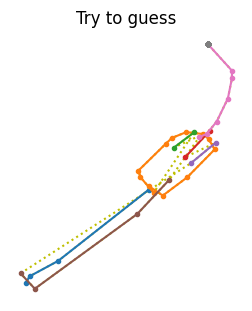

Top-5 predictions:
 1. syringe 16.849%
 2. feather 8.358%
 3. screwdriver 5.918%
 4. sun 4.894%
 5. mosquito 3.643%
answer: paintbrush


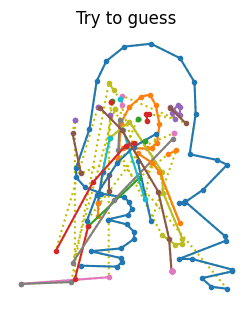

Top-5 predictions:
 1. lion 4.398%
 2. brain 4.272%
 3. camouflage 3.660%
 4. broccoli 3.619%
 5. parachute 3.051%
answer: frog


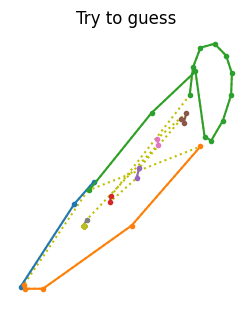

Top-5 predictions:
 1. syringe 21.109%
 2. flashlight 6.738%
 3. garden hose 5.546%
 4. paintbrush 5.103%
 5. rifle 5.063%
answer: clarinet


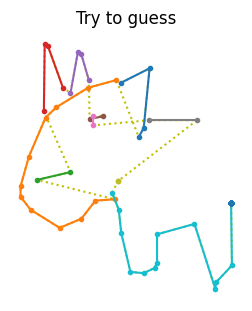

Top-5 predictions:
 1. rhinoceros 21.095%
 2. animal migration 8.806%
 3. bat 6.369%
 4. crab 5.773%
 5. crocodile 4.593%
answer: rhinoceros


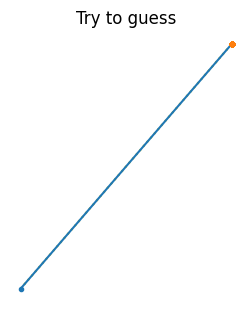

Top-5 predictions:
 1. line 22.814%
 2. smiley face 7.471%
 3. stitches 5.606%
 4. rain 3.261%
 5. stop sign 3.112%
answer: squiggle


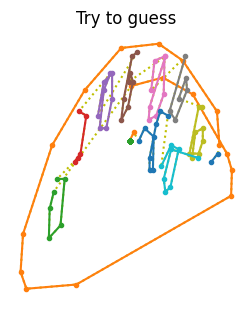

Top-5 predictions:
 1. peas 45.629%
 2. string bean 24.296%
 3. blackberry 2.968%
 4. bracelet 2.871%
 5. stop sign 2.226%
answer: cookie


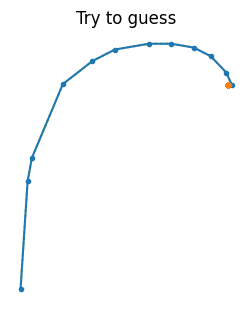

Top-5 predictions:
 1. streetlight 38.661%
 2. matches 10.334%
 3. lollipop 10.147%
 4. nail 4.521%
 5. knee 3.111%
answer: streetlight


In [19]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
  plt.figure(figsize=(3, 3.5))
  draw_sketch(sketches[index])
  plt.show()
  print("Top-5 predictions:".format(index + 1))
  for k in range(5):
    class_name = class_names[top_k.indices[index, k]]
    proba = 100 * top_k.values[index, k]
    print(" {}. {} {:.3f}%".format(k + 1, class_name, proba))
  print("answer: {}".format(class_names[labels[index].numpy()]))


In [20]:
model.save("my_sketchrnn")